<a href="https://colab.research.google.com/github/jpgarciaortiz/DWT-ANN/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previous steps


Download MRVC code from GitHub

In [1]:
!rm -rf MRVC ; git clone https://github.com/jpgarciaortiz/MRVC.git

Cloning into 'MRVC'...
remote: Enumerating objects: 5143, done.
remote: Counting objects: 100% (930/930), done.
remote: Compressing objects: 100% (247/247), done.
remote: Total 5143 (delta 686), reused 922 (delta 678), pack-reused 4213
Receiving objects: 100% (5143/5143), 203.96 MiB | 31.06 MiB/s, done.
Resolving deltas: 100% (2654/2654), done.


Add the MRVC to the source path

In [2]:
import sys
sys.path.append("MRVC/src")

Install additional packages

In [3]:
!pip install colored

     |████████████████████████████████| 56 kB 2.2 MB/s 
  Created wheel for colored: filename=colored-1.4.2-py3-none-any.whl size=14023 sha256=3cf9e1540deee71ddc355a56887e0e14980cdae59edc97733a482d2eaf65e3f2
  Stored in directory: /root/.cache/pip/wheels/5f/e1/fb/d0e85a8383ff58962319bb81c46e398fa1f4bb9e1feb0f81c4
Successfully built colored


In [4]:
!pip install ISR

     |████████████████████████████████| 86.3 MB 37 kB/s 
     |████████████████████████████████| 449 kB 57.0 MB/s 
     |████████████████████████████████| 3.8 MB 19.8 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f9ca6975ba1a926ff50556ddce814b48bc992c456a2c7ede98497feb1434410b
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.6.0
    Uninstalling tensorboard-2.6.0:
      Successfully uninstalled tensorboard-2.6.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Success

In [3]:
import numpy as np
from PIL import Image

In [4]:
img = Image.open('MRVC/sequences/lena_color/000.png')
lr_img = np.array(img)

In [1]:
!pip install 'h5py<3.0.0'

In [6]:
from ISR.models import RDN

rdn = RDN(weights='psnr-small')
sr_img = rdn.predict(lr_img)
img2 = Image.fromarray(sr_img)

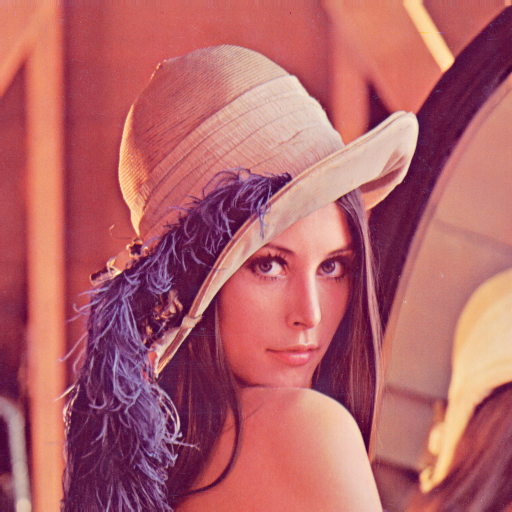

In [10]:
img

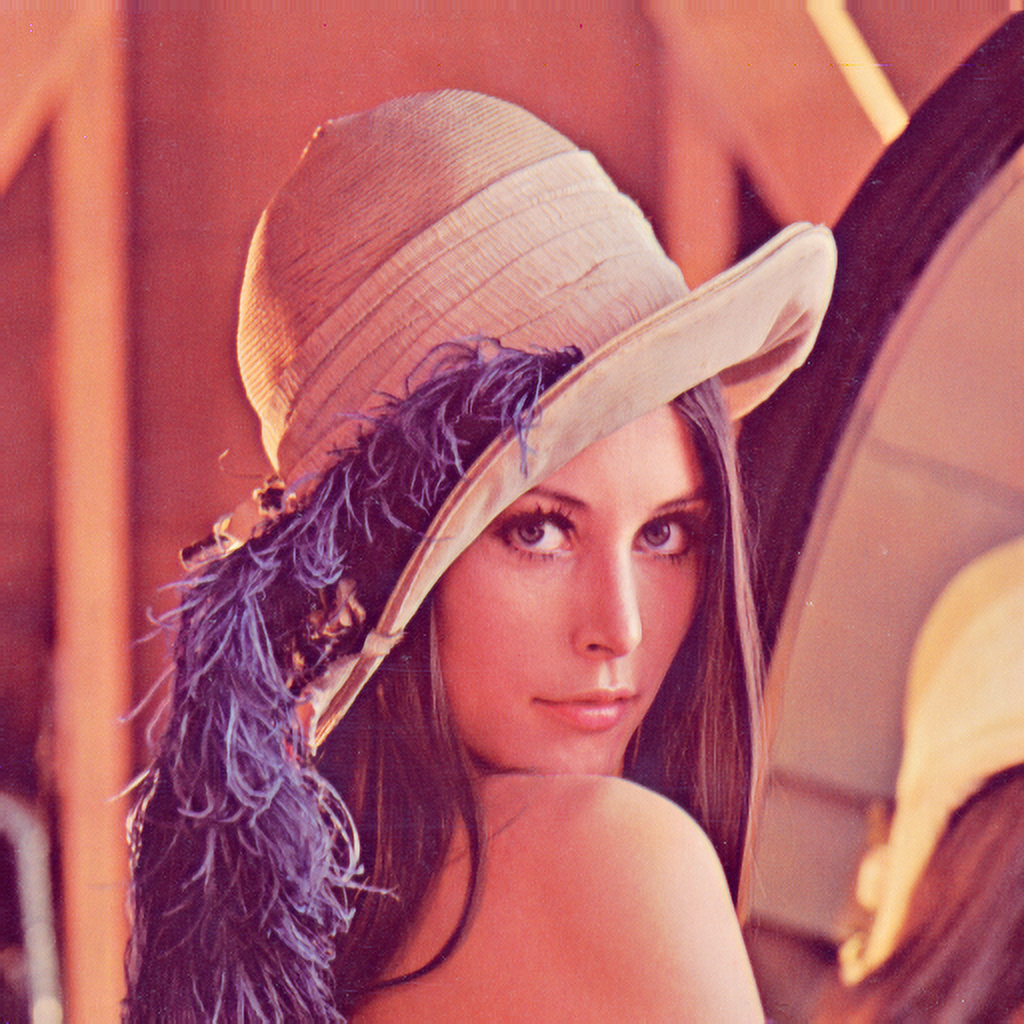

In [9]:
img2

# DWT (Discrete Wavelet Transform) Image Compression

How to compress images using the DWT.

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
%matplotlib inline
import image_3 as image
import image_1 as component
import DWT
import pywt
import distortion
import YCoCg as YUV
import deadzone as Q
import math
import information

## Global parameters of the notebook

In [ ]:
test_image = "MRVC/sequences/lena_color/"
res_path = "output/"
N_levels = 6
Q_steps = [128, 64, 32, 16, 8, 4, 2, 1]
N_components = 3

#wavelet = pywt.Wavelet("Haar")
#wavelet = pywt.Wavelet("db1")
#wavelet = pywt.Wavelet("db5")
#wavelet = pywt.Wavelet("db15")
#wavelet = pywt.Wavelet("bior3.1")
#wavelet = pywt.Wavelet("bior3.3")
wavelet = pywt.Wavelet("bior5.5")
#print(wavelet)

## First ... some handy routines

In [ ]:
def __read_image(prefix):
    x = image.read(prefix, 0)
    if len(x.shape) == 2:
        extended_x = np.zeros(shape=(x.shape[0],  x.shape[1], 3), dtype=np.uint16) 
        extended_x[..., 0] = x
        return extended_x
    else:
        return x

def _write_compact_decomposition(decom, prefix, image_number):
    rows = decom[len(decom)-1][0].shape[0]*2
    cols = decom[len(decom)-1][0].shape[1]*2
    coms = decom[0].shape[2]
    image_shape = (rows, cols, coms)
    view = np.empty(image_shape, np.uint16)

    # LL subband
    view[0:decom[0].shape[0],
         0:decom[0].shape[1]] = (decom[0].astype(np.int32) + 32768).astype(np.uint16)

    for l in range(len(decom)-1):

        # LH
        view[0:decom[l+1][0].shape[0],
             decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] =\
                (decom[l+1][0].astype(np.int32) + 32768).astype(np.uint16)

        # HL
        view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
             0:decom[l+1][1].shape[1]] =\
                (decom[l+1][1].astype(np.int32) + 32768).astype(np.uint16)

        # HH
        view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
             decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] =\
                (decom[l+1][2].astype(np.int32) + 32768).astype(np.uint16)
            
    return image.write(view, prefix, image_number)
    
def write_compact_decomposition(decom, prefix, image_number):
    rows = decom[len(decom)-1][0].shape[0]*2
    cols = decom[len(decom)-1][0].shape[1]*2
    coms = decom[0].shape[2]
    image_shape = (rows, cols, coms)
    view = np.empty(image_shape, np.uint8)

    # LL subband
    view[0:decom[0].shape[0],
         0:decom[0].shape[1]] = (decom[0].astype(np.int16) + 128).astype(np.uint16)

    for l in range(len(decom)-1):

        # LH
        view[0:decom[l+1][0].shape[0],
             decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] =\
                (decom[l+1][0].astype(np.int16) + 128).astype(np.uint16)

        # HL
        view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
             0:decom[l+1][1].shape[1]] =\
                (decom[l+1][1].astype(np.int16) + 128).astype(np.uint16)

        # HH
        view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
             decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] =\
                (decom[l+1][2].astype(np.int16) + 128).astype(np.uint16)
            
    return image.write(view, prefix, image_number)

def read_compact_decomposition(prefix, image_number, N_levels):
    view = image.read(prefix, image_number)
    wavelet = pywt.Wavelet("Haar")
    decom = DWT.analyze(np.zeros_like(view), wavelet, N_levels)
    
    # LL subband
    decom[0][...] = view[0:decom[0].shape[0],
                         0:decom[0].shape[1]] - 32768
    
    for l in range(len(N_levels)):
        
        # LH
        decom[l+1][0] =\
            view[0:decom[l+1][0].shape[0],
                 decom[l+1][0].shape[1]:decom[l+1][0].shape[1]*2] - 32668
            
        # HL
        decom[l+1][1] =\
            view[decom[l+1][1].shape[0]:decom[l+1][1].shape[0]*2,
                 0:decom[l+1][1].shape[1]] - 32768
            
        # HH
        decom[l+1][2] =\
            view[decom[l+1][2].shape[0]:decom[l+1][2].shape[0]*2,
                 decom[l+1][2].shape[1]:decom[l+1][2].shape[1]*2] - 32768

    return decom

def entropy(decomposition):
    entro = information.entropy(decomposition[0].flatten().astype(np.int16))
    accumulated_entropy = entro * decomposition[0].size
    image_size = decomposition[0].size
    for sr in y[1:]:
        for sb in sr:
            entro = information.entropy(sb.flatten().astype(np.int16))
            accumulated_entropy += (entro * sb.size)
            image_size += sb.size
    avg_entropy = accumulated_entropy / image_size
    return avg_entropy

## Testing `DWT.analyze_step()` and `DCT.synthesize_step()`

In [ ]:
x = image.read(test_image)
image.show(x, title="Original")

In [ ]:
L, H = DWT.analyze_step(x, wavelet)

In [ ]:
image.show(image.normalize(L), "LL DWT domain")
subbands = ("LH", "HL", "HH")
for i, sb in enumerate(subbands):
    image.show(image.normalize(H[i]), f"{sb} DWT domain")

In [ ]:
z = DWT.synthesize_step(L, H, wavelet).astype(np.uint8)

In [ ]:
image.show(image.normalize(x - z), 
           f"DWT finite precission error\nN_DWT_levels={N_levels}\n")

The DWT is not fully reversible, but it is almost.

In [ ]:
image.show(z, "Reconstructed image")

## Testing `DWT.analyze()` and `DCT.synthesize()`

In [ ]:
y = DWT.analyze(x, wavelet, N_levels)
z = DWT.synthesize(y, wavelet, N_levels).astype(np.uint8)

In [ ]:
image.show(image.normalize(x - z), 
           f"DWT finite precission error\nN_DWT_levels={N_levels}\nMSE={distortion.MSE(x, z)}\n")

In [ ]:
image.show(z, "Reconstructed image")

## Subbands/components information

In [ ]:
x = image.read(test_image)
xx = YUV.from_RGB(x.astype(np.int16) - 128) # -128 decreases maximum value of the DC coefficients
yy = DWT.analyze(xx, wavelet, N_levels)
print("sbc maximum mininum max-min average std-dev entropy        energy  avg-enegy")
entropy = information.entropy(yy[0].flatten().astype(np.int16))
accumulated_entropy = entropy * yy[0].size
print(f"  0 {yy[0].max():7.1f} {yy[0].min():7.1f} {yy[0].max()-yy[0].min():7.1f} {np.average(yy[0]):7.1f} {math.sqrt(np.var(yy[0])):7.1f} {entropy:7.1f} {information.energy(yy[0]):13.1f} {information.energy(yy[0])/yy[0].size:10.1f}")
sbc_index = 1
for sr in yy[1:]:
    for sb in sr:
        for c in range(N_components):
            sbc = sb[..., c]
            entropy = information.entropy(sbc.flatten().astype(np.int16))
            accumulated_entropy += (entropy * sbc.size)
            max = sbc.max()
            min = sbc.min()
            max_min = max - min
            print(f"{sbc_index:3d} {max:7.1f} {min:7.1f} {max_min:7.1f} {np.average(sbc):7.1f} {math.sqrt(np.var(sbc)):7.1f} {entropy:7.1f} {information.energy(sbc):13.1f} {information.energy(sbc)/sbc.size:10.1f}")
            sbc_index += 1
avg_entropy = accumulated_entropy / x.size
print("Average entropy in the wavelet domain:", avg_entropy)
print("Entropy in the image domain:", information.entropy(x.flatten().astype(np.uint8)))

As it can be seen:
1. Most of the energy (and entropy, i.e., information) is concentrated in the low-frequency subbands.
2. The wavelet domain is potentially more compressible than the image domain, because the entropy is smaller.
3. The number of bits required for representing the low-frequency subbands is significantly higher than the original 8-bits/component (for example, for lena, 5 levels of the DWT, and the Biorthogonal 5/3 kernels, 15 bits/coefficient are required). This number depends on the wavelet filters, the number of levels of the transform, and the original image.

## Quantization steps

The high dynamic range of the wavelet coefficients dificults the use 8-bit RGB PNG encoding, which is more compact that the 16-bit version. At this point, we have basically two alternatives:
1. Use a set of high enough quantization steps to keep the quantization indexes into 8 bits (for the previous example, [4096, 2048, 1024, 512, 256, 128]). However, notice that this probably is going to ignore most of the information of the high-frequency subbands because the amplitude of their coefficients are smaller than the smaller quantization step.
2. If the quality provided by the smaller quantization step is not enough, the unencoded (least significant) bit-planes of the coefficients can be compressed in a second 8-bit PNG image.

In [ ]:
#Q_steps = [4096, 2048, 1024, 512, 256, 128]
#Q_steps = [256, 128, 64, 32, 16]
Q_steps = [64, 32, 16, 8]
#Q_steps = [2]

## RD performance using uniform quantization among subbands

Compute the RD cuve of using uniform quantization in the YCoCg/wavelet domain. To estimate the distortion in the image domain, we will suppose that the DWT is (bi)orthogonal (remember that the alternative for non-orthonal transforms is to apply the inverse transform for each quantization step of each subband-component, and measure the distortion in the image domain).

, for different quantization steps. To measure the distortion we have two alternatives:
1. Always considering that the transform is (bi)orthogonal and therefore, the distortion among subbands is uncorrelated, we can measure the quantization error in the wavelet domain, inside of the quantized subband, considering the inverse transform gain of such subband.
2. We can measure the distortion in the image domain, after inversely transforming the quantized decomposition. Obviously, this alternative is slower. However, this is the only choice is the transform is not (bi)orthogonal.

In [ ]:
x = image.read(test_image)
xx = YUV.from_RGB(x.astype(np.int16) - 128)
#xx = YUV.from_RGB(x.astype(np.int16))

DWT_points = []
for Q_step in Q_steps:
    yy = DWT.analyze(xx, wavelet, N_levels)
    LL = yy[0]
    LL_k = Q.quantize(LL, Q_step)
    LL_dQ = Q.dequantize(LL_k, Q_step)
    yy_k = [LL_k]
    yy_dQ = [LL_dQ]
    #dist = distortion.MSE(LL, LL_dQ)
    #MSE = (dist * LL.size)/x.size
    #print(gains[0], dist, gains[0] * dist, MSE)
    #for i in range(4):
    #    for j in range(4):
    #        print(LL[i, j], LL_dQ[i, j])
    for sr in yy[1:]:
        sr_k = []
        sr_dQ = []
        for sb in sr:
            #print(MSE)
            sb_k = Q.quantize(sb, Q_step)
            sb_dQ = Q.dequantize(sb_k, Q_step)
            sr_k.append(sb_k)
            sr_dQ.append(sb_dQ)
            #dist = distortion.MSE(sb, sb_dQ)
            #print(gains[counter], dist, gains[counter] * dist, MSE)
            #MSE += (dist * sb.size)/x.size
        yy_k.append(tuple(sr_k))
        yy_dQ.append(tuple(sr_dQ))
    BPP = (write_compact_decomposition(yy_k, f"/tmp/constant_{Q_step}_", 0)*8)/xx.size
    zz_dQ = DWT.synthesize(yy_dQ, wavelet, N_levels)
    #z_dQ = np.clip(YUV.to_RGB(zz_dQ), a_min=-128, a_max=127) + 128
    z_dQ = np.clip(YUV.to_RGB(zz_dQ) + 128, a_min=0, a_max=255)
    MSE = distortion.MSE(x, z_dQ)
    print(f"{Q_step} {BPP} {MSE}")
    DWT_points.append((BPP, MSE))
    image.show(z_dQ.astype(np.uint8), f"Reconstructed image (Q_step={Q_step})")

In [ ]:
DCT_points = []
with open("DCT.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        DCT_points.append((float(rate), float(_distortion)))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DCT_points), label=f"DCT optimal Q")
pylab.plot(*zip(*DWT_points), label=f"DWT constant Q")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

## Again ... can we increase the RD performance?

Let's do that, for a given quantization step, the subband-components contribute approximately the same to que quality of the reconstruction.

Algorithm:
1. Read the image.
2. Transform to the YCoCg domain.
3. Transform each component to the DWT domain.
4. Find the RD curve for each subband-component.
5. Compute the slope of each step of each curve and put all the slopes in the same list.
6. Sort the previous list by the slope field.
7. Find the RD curve that progressively uses decending slopes.

In [ ]:
# Read the image and move to the YCoCg domain.
x = image.read(test_image)
xx = YUV.from_RGB(x.astype(np.int16) - 128)

In [ ]:
# Compute the DWT
yy = DWT.analyze(xx, wavelet, N_levels)

In [ ]:
# Create a list of RD points for each RD curve (subband-component) and the corresponding lists of RD slopes between these points.
# The first coordinate of each point is the rate and the second coordinate is the corresponding distortion.
# For rate=0, the MSE is the energy of the subband-component.
# Notice that no slope can be computed for the first point.
RD_points = []
RD_slopes = []
for _c in range(N_components):
    sbc = yy[0][..., _c]
    RD_points.append([(0, information.energy(sbc) / sbc.size)]) # Work with MSE's that are average distortions
    RD_slopes.append([])
for sr in yy[1:]:
    for sb in sr:
        for _c in range(N_components):
            sbc = sb[..., _c]
            sbc_avg_energy = information.energy(sbc) / sbc.size
            # The first point of each RD curve has a maximum distortion equal
            # to the energy of the subband and a rate = 0
            RD_points.append([(0, sbc_avg_energy)])
            RD_slopes.append([])

In [ ]:
for _i,_j in enumerate(RD_points):
    print(_i,_j)
    
for _i,_j in enumerate(RD_slopes):
    print(_i,_j)

In [ ]:
def estimate_codestream_len(x, prefix):
    empty_x = np.zeros_like(x)
    real_BPP = component.write(x.astype(np.uint8), prefix)
    empty_BPP = component.write(empty_x.astype(np.uint8), prefix)
    return real_BPP - empty_BPP
    #return information.entropy(x.astype(np.int16).flatten())*x.size

In [ ]:
# Populate the rest of points of each curve (subband-component).
# Distortion is measured in the transform domain.

# Subband LL
for _c in range(N_components):
    sbc = yy[0][..., _c]
    Q_step_number = 0
    for Q_step in Q_steps:
        sbc_k = Q.quantize(sbc, Q_step)
        sbc_dQ = Q.dequantize(sbc_k, Q_step)
        MSE = distortion.MSE(sbc, sbc_dQ)
        BPP = estimate_codestream_len(sbc_k, f"/tmp/{_c}_{Q_step}_")*8/xx.size
        #BPP = component.write(sbc_k.astype(np.uint8), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
        #BPP = information.PNG_BPP((sbc_k.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
        #sbc_BPP = information.entropy(sbc_k.astype(np.int16).flatten())
        point = (BPP, MSE)
        RD_points[_c].append(point)
        delta_BPP = BPP - RD_points[_c][Q_step_number][0]
        delta_MSE = RD_points[_c][Q_step_number][1] - MSE
        if delta_BPP > 0:
            slope = delta_MSE/delta_BPP
        else:
            slope = 0#100**10
        print("Q_step =", Q_step, "BPP =", point[0], "MSE =", point[1], "slope =", slope)
        RD_slopes[_c].append((Q_step, slope, _c))
        Q_step_number += 1

# Rest of subbands
sbc_number = 3
for sr in yy[1:]:
    for sb in sr:
        for _c in range(N_components):
            sbc = sb[..., _c]
            Q_step_number = 0
            for Q_step in Q_steps:
                sbc_k = Q.quantize(sbc, Q_step)
                sbc_dQ = Q.dequantize(sbc_k, Q_step)
                MSE = distortion.MSE(sbc, sbc_dQ)
                BPP = estimate_codestream_len(sbc_k, f"/tmp/{sbc_number}_{Q_step}_")*8/xx.size
                #BPP = component.write(sbc_k.astype(np.uint8), f"/tmp/{sbc_number}_{Q_step}_", 0)*8/sbc.size
                #BPP = information.PNG_BPP((sbc_k.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
                #sbc_BPP = information.entropy(sbc_k.astype(np.int16).flatten())
                point = (BPP, MSE)
                RD_points[sbc_number].append(point)
                delta_BPP = BPP - RD_points[sbc_number][Q_step_number][0]
                delta_MSE = RD_points[sbc_number][Q_step_number][1] - MSE
                if delta_BPP > 0:
                    slope = delta_MSE/delta_BPP
                else:
                    slope = 0#100**10
                print("Q_step =", Q_step, "BPP =", point[0], "MSE =", point[1], "slope =", slope)
                RD_slopes[sbc_number].append((Q_step, slope, sbc_number))
                Q_step_number += 1
            sbc_number += 1

In [ ]:
for _i, _j in enumerate(RD_points):
    print(_i, "---", _j)

In [ ]:
for _i, _j in enumerate(RD_slopes):
    print(_i, "---", _j)

In [ ]:
# Show the slopes
RD_slopes_without_sbc_index = []
#RD_slopes_without_sbc_index.append([])
for _c in range(N_components):
    RD_slopes_without_sbc_index.append([])
for sr in yy[1:]:
    for sb in sr:
        for _c in range(N_components):
            RD_slopes_without_sbc_index.append([])
for Q_step in range(len(Q_steps)):
    RD_slopes_without_sbc_index[0].append(RD_slopes[0][Q_step][0:2])
sbc_number = 3
for sr in yy[1:]:
    for sb in sr:
        for _c in range(N_components):
            for Q_step in range(len(Q_steps)):
                RD_slopes_without_sbc_index[sbc_number].append(RD_slopes[sbc_number][Q_step][0:2])
            sbc_number += 1
print(RD_slopes_without_sbc_index[0])
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_slopes_without_sbc_index[0]), label="0", marker=0)
for sbc_number in range(10):
    pylab.plot(*zip(*RD_slopes_without_sbc_index[sbc_number]), label=f"{sbc_number}", marker=sbc_number)
pylab.title("Slopes of the RD curves of the subbands")
pylab.xlabel("Q_step")
pylab.ylabel("Slope")
plt.legend(loc="best")
pylab.show()

In [ ]:
# Sort the slopes
single_list = []
for Q_step in range(len(Q_steps)):
    single_list.append(tuple(RD_slopes[0][Q_step]))
sbc_number = 1
for sr in yy[1:]:
    for sb in sr:
        for _c in range(N_components):
            for Q_step in range(len(Q_steps)):
                single_list.append(tuple(RD_slopes[sbc_number][Q_step]))
            sbc_number += 1
sorted_slopes = sorted(single_list, key=lambda _x: _x[1])[::-1]

In [ ]:
sorted_slopes

In [ ]:
def show(d, s):
    c = 0
    for i in d[0]:
        print(s, i, end=' ')
        c += 1
        if c > 3:
            break
    for sr in d[1:]:
        for sb in sr:
            c = 0
            for i in sb:
                print(s, i, end=' ')
                c += 1
                if c > 3:
                    break
    print()

def _quantize(decom, Q_steps):
    decom_k = []
    decom_k.append(Q.quantize_components(decom[0], Q_steps[0:3]))
    for sr in decom[1:]:
        decom_k.append(Q.sr)
    print()
    return decom_k

def _dequantize(decom_k, Q_steps):
    decom_dQ = []
    decom_dQ.append(decom_k[0])
    for sr_k in decom_k[1:]:
        decom_dQ.append(sr_k)
    print()
    return decom_dQ
    
def quantize_components(x, Q_steps):
    '''Quantize each component of <x> using an independent quantization step.'''
    x_k = np.empty_like(x, dtype=np.int16)
    for c in range(x.shape[2]):
        x_k[..., c] = Q.quantize(x[..., c], Q_steps[c])
    return x_k

def quantize(decom, Q_steps):
    decom_k = []
    #decom_k.append(decom[0])
    decom_k.append(quantize_components(decom[0], Q_steps[0:3]))
    sbc_number = 3
    for sr in decom[1:]:
        sr_k = []
        for sb in sr:
            sb_k = quantize_components(sb, Q_steps[sbc_number:sbc_number + 3])
            sr_k.append(sb_k)
            sbc_number += 3
        #decom_k.append(sr)
        decom_k.append(tuple(sr_k))
    return decom_k

def dequantize_components(x_k, Q_steps):
    '''Dequantize each component of <x_k> using an independent quantization step.'''
    x_dQ = np.empty_like(x_k, dtype=np.int32)
    for c in range(x_k.shape[2]):
        x_dQ[..., c] = Q.dequantize(x_k[..., c], Q_steps[c])
    return x_dQ

def dequantize(decom_k, Q_steps):
    decom_dQ = []
    #decom_dQ.append(decom_k[0])
    decom_dQ.append(dequantize_components(decom_k[0], Q_steps[0:3]))
    sbc_number = 3
    for sr_k in decom_k[1:]:
        sr_dQ = []
        for sb_k in sr_k:
            sb_dQ = dequantize_components(sb_k, Q_steps[sbc_number:sbc_number + 3])
            sr_dQ.append(sb_dQ)
            sbc_number += 3
        #decom_dQ.append(sr_k)
        decom_dQ.append(tuple(sr_dQ))
    return decom_dQ
    
def quantize_sr(sr, Q_step):
    '''Quantize a spatial resolution of the DWT (3 multicomponent subbands) using
    3*N_components independent quantization steps'''
    return tuple([Q.quantize(i, Q_step) for i in sr])

def _quantize(decomposition, Q_steps):
    LL = decomposition[0]
    LL_k = np.empty_like(LL, dtype=np.int16)
    for _c in range(N_components):
        LLc = LL[..., _c]
        LL_k[..., _c] = LLc # Q.quantize(LLc, Q_steps[_c])
    decomposition_k = [LL_k]
    sbc_number = 3
    for sr in decomposition[1:]:
        #print("sr", len(sr))
        sr_k = []
        for sb in sr:
            sbc_k = np.empty_like(sb)
            for _c in range(N_components):
                sbc = sb[..., _c]
                #print(len(Q_steps), sbc_number)
                sbc_k[..., _c] = sbc # Q.quantize(sbc, Q_steps[sbc_number])
                #sbc_k = Q.quantize(sbc, Q_steps[sbc_number])
                sbc_number += 1
            sr_k.append(sbc_k)
        decomposition_k.append(tuple(sr_k))
    return decomposition
    #return decomposition_k

def _dequantize(decomposition_k, Q_steps):
    LL_k = decomposition_k[0]
    LL_dQ = np.empty_like(LL_k).astype(np.float64)
    for _c in range(N_components):
        LLc_k = LL_k[..., _c]
        LL_dQ[..., _c] = LLc_k# Q.dequantize(LLc_k, Q_steps[_c])
    decomposition_dQ = [LL_dQ]
    sbc_number = 3
    for sr_k in decomposition_k[1:]:
        sr_dQ = []
        #print("sr_k", len(sr_k))
        for sb_k in sr_k:
            sbc_dQ = np.empty_like(sb_k).astype(np.float64)
            for _c in range(N_components):
                sbc_k = sb_k[..., _c]
                #print(len(Q_steps), sbc_number)
                sbc_dQ[..., _c] = sbc_k #Q.dequantize(sbc_k, Q_steps[sbc_number])
                sr_dQ.append(sbc_dQ)
                sbc_number += 1
        decomposition_dQ.append(tuple(sr_dQ))
    return decomposition_k
    #return decomposition_dQ

def resolution_level(sb_number):
    '''Resolution level in decomposition.'''
    if sb_number > 0:
        return ((sb_number - 1) // 3) + 1
    else:
        return 0
    
def subband_index(sb_number):
    '''Subband index in resolution level.'''
    if sb_number > 0:
        return (sb_number % 3) - 1
    else:
        return 0

In [ ]:
# Find the optimal RD curve
optimal_RD_points = []
#y_prog = DWT.analyze(np.zeros_like(x), wavelet, N_levels)
#print(len(y_prog))
Q_steps_of_decomposition = 3*[100**10]
#Q_steps_of_decomposition = 3*[1]
#for sr in y_prog[1:]:
for sr in yy[1:]:
    #print(len(sr))
    for sb in sr:
        for _c in range(N_components):
            Q_steps_of_decomposition.append(100**10)
            #Q_steps_of_decomposition.append(1)
#print(Q_steps_by_subband)
slope_index = 0
for s in sorted_slopes:
    sbc_number = s[2]
    #print("sb_number", sb_number)
    Q_steps_of_decomposition[sbc_number] = s[0]
    #print(sb_number, Q_steps_by_subband[sb_number])
    #y_prog[resolution_level(sb_number)][subband_index(sb_number)] = y[resolution_level(sb_number)][subband_index(sb_number)]
    #y_k = quantize(y_prog, Q_steps_by_subband)
    yy_k = quantize(yy, Q_steps_of_decomposition)
    BPP = (write_compact_decomposition(yy_k, f"/tmp/optimal_{slope_index}_", 0)*8)/xx.size
    #BPP = entropy(y_k)
    yy_dQ = dequantize(yy_k, Q_steps_of_decomposition)
    #show(yy, '+')
    #show(yy_dQ, '-')
    #for _sr, _sr_dQ in zip(yy[1:], yy_dQ[1:]):
    #    for _sbc, _sbc_dQ in zip(_sr, _sr_dQ):
    #        print(_sbc.astype(np.int), sbc_dQ.astype(np.int))
    zz_dQ = DWT.synthesize(yy_dQ, wavelet, N_levels)
    #zz_dQ = DWT.synthesize(yy, wavelet, N_levels)
    z_dQ = np.clip(YUV.to_RGB(zz_dQ), a_min=-128, a_max=127) + 128
    #z_dQ = np.clip(YUV.to_RGB(zz_dQ), a_min=0, a_max=255)
    #image.show(z_dQ.astype(np.uint8))
    #print(yy[0].astype(np.int), yy_k[0], yy_dQ[0])
    #print(yy_k[0].dtype)
    MSE = distortion.MSE(x, z_dQ)
    print(f"{Q_steps_of_decomposition} {BPP} {MSE}")
    optimal_RD_points.append((BPP, MSE))
    #image.show_RGB_image(zz_dQ, f"Reconstructed image (Q_step={Q_step})")
    slope_index += 1


In [ ]:
optimal_RD_points

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DWT_points), label="Uniform quantization")
pylab.plot(*zip(*optimal_RD_points), label="Optimal quantization")
pylab.plot(*zip(*DCT_points), label="DCT")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

## Ignore the rest ...

## Uniform quantization vs optimal quantization

As we did with the DCT, let's compare both types of quantization in the RD space. Steps:

1. Compute the RD slope of each subband for a set of quantization steps. For this we will suppose that the subbands are independent (the DWT is orthogonal), measuring the distortion in the wavelet domain.
2. Sort the slopes. This will determine the optimal progression of quantization steps (which subband to incorporate more data to the code-stream, progressively).
3. Compute the distortion in the image domain for each bit-rate. Notice that this information should match with the privided by the step 1 (measuring the distortion in the wavelet domain). However, we prefer to computate the distortion in the image domain because the transform does not need to be orthogonal.

 Read the image, move to the YUV domain, and compute the DWT.

In [ ]:
xx = read_image(test_image)
x = YUV.from_RGB(xx.astype(np.int16) - 128)
y = DWT.analyze(x, wavelet, N_levels)

For each subband, we populate:
1. A list of RD points, and
2. A list of RD slopes with these points, indicanting also the corresponding quantization step and subband.

Remember that we have a RD point for each quantization step for each subband. The first dimension of these lists is indexed the subband, and the second dimension is indexed by the quantization step.

In [ ]:
# For BPP=0, the MSE is the energy of the subband. No slope can be computed for the first point.
RD_points = [[(0, information.energy(y[0]) / y[0].size)]] # Work with MSE's that are average distortions
RD_slopes = [[]]
for sr in y[1:]:
    for sb in sr:
        sb_avg_energy = information.energy(sb) / sb.size
        # The first point of each RD curve has a maximum distortion equal
        # to the energy of the subband and a rate = 0
        RD_points.append([(0, sb_avg_energy)])
        RD_slopes.append([])

for i,j in enumerate(RD_points):
    print(i,j)
    
for i,j in enumerate(RD_slopes):
    print(i,j)

In [ ]:
# Now populate the rest of points of each subband

# Subband LL
sb_number = 0
sb = y[0]
Q_step_number = 0
for Q_step in Q_steps:
    print(Q_steps)
    sb_k = Q.quantize(sb, Q_step)
    sb_dQ = Q.dequantize(sb_k, Q_step)
    sb_MSE = distortion.MSE(sb, sb_dQ)
    sb_BPP = information.PNG_BPP((sb_k.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
    #sb_BPP = information.entropy(sb_k.astype(np.int16).flatten())
    RD_points[sb_number].append((sb_BPP, sb_MSE))
    delta_BPP = sb_BPP - RD_points[sb_number][Q_step_number][0]
    delta_MSE = RD_points[sb_number][Q_step_number][1] - sb_MSE
    if delta_BPP > 0:
        slope = delta_MSE/delta_BPP
    else:
        slope = 0
    RD_slopes[sb_number].append((Q_step, slope, (sb_number)))
    Q_step_number += 1

print(N_levels)
    
for i,j in enumerate(RD_points):
    print(i, "---", j)
    
for i,j in enumerate(RD_slopes):
    print(i, "---", j)

In [ ]:
sb_number = 1
for sr in y[1:]:
    for sb in sr:
        Q_step_number = 0
        for Q_step in Q_steps:
            sb_k = Q.quantize(sb, Q_step)
            sb_dQ = Q.dequantize(sb_k, Q_step)
            sb_MSE = distortion.MSE(sb, sb_dQ)
            sb_BPP = information.PNG_BPP((sb_k.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
            #sb_BPP = information.entropy(sb_k.astype(np.int16).flatten())
            RD_points[sb_number].append((sb_BPP, sb_MSE))
            delta_BPP = sb_BPP - RD_points[sb_number][Q_step_number][0]
            delta_MSE = RD_points[sb_number][Q_step_number][1] - sb_MSE
            if delta_BPP > 0:
                slope = delta_MSE/delta_BPP
            else:
                slope = 9^9
            print(sb_number, len(y))
            RD_slopes[sb_number].append((Q_step, slope, (sb_number)))
            Q_step_number += 1
        sb_number += 1
        
for i,j in enumerate(RD_points):
    print(i, "---", j)
    
for i,j in enumerate(RD_slopes):
    print(i, "---", j)

In [ ]:
RD_slopes

In [ ]:
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_points[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_points[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("RD curves of the subbands")
    pylab.xlabel("Bits/Pixel")
    pylab.ylabel("MSE")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_points[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_points[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("RD curves of the subbands")
    pylab.xlabel("Bits/Pixel")
    pylab.ylabel("MSE")
    pylab.yscale("log")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
RD_slopes_without_sb_index = []
RD_slopes_without_sb_index.append([])
for sr in y[1:]:
    for sb in sr:
        RD_slopes_without_sb_index.append([])
for Q_step in range(len(Q_steps)):
    RD_slopes_without_sb_index[0].append(RD_slopes[0][Q_step][0:2])
sb_number = 1
for sr in y[1:]:
    for sb in sr:
        for Q_step in range(len(Q_steps)):
            RD_slopes_without_sb_index[sb_number].append(RD_slopes[sb_number][Q_step][0:2])
        sb_number += 1
print(RD_slopes_without_sb_index[0])
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_slopes_without_sb_index[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_slopes_without_sb_index[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
if sb_number < 12:
    pylab.figure(dpi=150)
    pylab.plot(*zip(*RD_slopes_without_sb_index[0]), label="0", marker=0)
    sb_number = 1
    for sr in y[1:]:
        for sb in sr:
            pylab.plot(*zip(*RD_slopes_without_sb_index[sb_number]), label=f"{sb_number}", marker=sb_number)
            sb_number += 1
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    pylab.yscale("log")
    plt.legend(loc="best")
    pylab.show()

It can be seen that the slopes of the curves are quite similar, but the LL subband is somewhat steeper.

Let's sort the slopes.

In [ ]:
single_list = []
for Q_step in range(len(Q_steps)):
    single_list.append(tuple(RD_slopes[0][Q_step]))
sb_number = 1
for sr in y[1:]:
    for sb in sr:
        for Q_step in range(len(Q_steps)):
            single_list.append(tuple(RD_slopes[sb_number][Q_step]))
        sb_number += 1
sorted_slopes = sorted(single_list, key=lambda x: x[1])[::-1]

In [ ]:
sorted_slopes

In [ ]:
def quantize(decomposition, Q_steps):
    #print(Q_steps)
    LL = decomposition[0]
    LL_k = Q.quantize(LL, Q_steps[0])
    decomposition_k = [LL_k]
    sb_number = 1
    for sr in decomposition[1:]:
        sr_k = []
        for sb in sr:
            #print(sb_number)
            sb_k = Q.quantize(sb, Q_steps[sb_number])
            sr_k.append(sb_k)
            sb_number += 1
        decomposition_k.append(tuple(sr_k))
    return decomposition_k

def dequantize(decomposition_k, Q_steps):
    LL_k = decomposition_k[0]
    LL_dQ = Q.dequantize(LL_k, Q_steps[0])
    decomposition_dQ = [LL_dQ]
    sb_number = 1
    for sr_k in decomposition_k[1:]:
        sr_dQ = []
        for sb_k in sr_k:
            sb_dQ = Q.dequantize(sb_k, Q_steps[sb_number])
            sr_dQ.append(sb_dQ)
            sb_number += 1
        decomposition_dQ.append(tuple(sr_dQ))
    return decomposition_dQ

def resolution_level(sb_number):
    '''Resolution level in decomposition.'''
    if sb_number > 0:
        return ((sb_number - 1) // 3) + 1
    else:
        return 0
    
def subband_index(sb_number):
    '''Subband index in resolution level.'''
    if sb_number > 0:
        return (sb_number % 3) - 1
    else:
        return 0

In [ ]:
optimal_RD_points = []
#y_prog = DWT.analyze(np.zeros_like(x), wavelet, N_levels)
#print(len(y_prog))
Q_steps_by_subband = [9**9]
#for sr in y_prog[1:]:
for sr in y[1:]:
    #print(len(sr))
    for sb in sr:
        Q_steps_by_subband.append(9**9)
#print(Q_steps_by_subband)
slope_index = 0
for s in sorted_slopes:
    sb_number = s[2]
    #print("sb_number", sb_number)
    Q_steps_by_subband[sb_number] = s[0]
    #print(sb_number, Q_steps_by_subband[sb_number])
    #y_prog[resolution_level(sb_number)][subband_index(sb_number)] = y[resolution_level(sb_number)][subband_index(sb_number)]
    #y_k = quantize(y_prog, Q_steps_by_subband)
    y_k = quantize(y, Q_steps_by_subband)
    BPP = (write_compact_decomposition(y_k, f"/tmp/optimal_{slope_index}_", 0)*8)/xx.size
    #BPP = entropy(y_k)
    slope_index += 1
    y_dQ = dequantize(y_k, Q_steps_by_subband)
    z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
    zz_dQ = np.clip(YUV.to_RGB(z_dQ), a_min=-128, a_max=127) + 128
    MSE = distortion.MSE(xx, zz_dQ)
    print(f"{Q_steps_by_subband} {BPP} {MSE}")
    optimal_RD_points.append((BPP, MSE))
    #image.show_RGB_image(zz_dQ, f"Reconstructed image (Q_step={Q_step})")

In [ ]:
optimal_RD_points

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*DWT_points), label="Uniform quantization")
pylab.plot(*zip(*optimal_RD_points), label="Optimal quantization")
#pylab.plot(*zip(*JPEG_RD_points), label="JPEG")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

# .......

ESTE PASO NO ES NECESARIO: Compute the average energy of the image and the decomposition.

In [ ]:
def energy(decomposition):
    accumulated_energy = information.energy(decomposition[0])
    for sr in y[1:]:
        for sb in sr:
            accumulated_energy += information.energy(sb)
    return accumulated_energy

In [ ]:
xx = read_image(test_image).astype(np.int16) - 128
#xx = np.full(shape=(512, 512, 3), fill_value=100) - 128
x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)
image_energy = information.average_energy(x)
print(image_energy)
print(energy(y)/x.size)

## Transform gains

This information measures whether the transform amplifies or attenuates the signal. If the forward transform amplifies the signal, the energy of the decomposition will be larger than the energy of the original signal, and viceversa. The same idea can be applied to the inverse transform.

In [ ]:
x = np.full(shape=(512, 512, 3), fill_value=1)
x_energy = information.energy(x)
y = DWT.analyze(x, wavelet, N_levels)
decom_energy = information.energy(y[0])
z = DWT.synthesize(y, wavelet, N_levels)
for sr in y[1:]:
    for sb in sr:
        decom_energy += information.energy(sb)
z_energy = information.energy(z)
print(wavelet)
print("Energy of the original image:", x_energy)
print("Energy of the decomposition:", decom_energy)
print("Energy of the reconstucted image:", z_energy)
print("Average energy of the original image", x_energy / x.size)
print("Average energy of the decomposition:", decom_energy / x.size)
print("Average energy of the reconstructed image:", z_energy / x.size)

As it can be seen, the transform is energy preserving, which means that we the distortion generated by quantization is the same in the image and the wavelet domains.

## Subband gains

All the wavelet transforms implemented by PyWavelets are unitary (preserve the energy). However, this not means that the subbands have the same gain. We can determine the subbands gain of the inverse transform giving a fixed amount of energy to each subband and computing the energy of the inverse transform of the decomposition. Finally, considering that the inverse transform has a gain of one, the gains are scaled to sum 1.

We are specially interested in the subband gains, considering the inverse transform, because in the compression process the subbands are quantized, and the quantization error is scaled by the gain of the subbands.

In [ ]:
gains = []
x = np.zeros(shape=(512, 512, 3))
y = DWT.analyze(x, wavelet, N_levels)
coeff_value = y[0].size
y[0][...] = coeff_value/y[0].size
z = DWT.synthesize(y, wavelet, N_levels)
gains.append(distortion.energy(z))
prev_sb = y[0]
for sr in y[1:]:
    for sb in sr:
        prev_sb[...] = 0.0
        sb[...] = coeff_value/sb.size
        z = DWT.synthesize(y, wavelet, N_levels)
        gains.append(distortion.energy(z))
        prev_sb = sb
        
x = np.empty(shape=(512, 512, 3))
y = DWT.analyze(x, wavelet, N_levels)
coeff_value = y[0].size
y[0][...] = coeff_value/y[0].size
for sr in y[1:]:
    for sb in sr:
        sb[...] = coeff_value/sb.size
z = DWT.synthesize(y, wavelet, N_levels)
z_energy = distortion.energy(z)

gains = [gain/z_energy for gain in gains]
print("Unitary (normalized) inverse transform subband gains:", gains)
np.testing.assert_almost_equal(sum(gains), 1.0)

## RD performance considering (and not) the subband gains

We compute the RD cuve of using scalar quantization when:
1. All subbands are quantized using the same quantization step.
2. The quantization step used in a subband is divided by the subband gain.

In [ ]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)

constant_Q_points = []
for Q_step in Q_steps:
    y = DWT.analyze(x, wavelet, N_levels)
    LL = y[0]
    LL_k = Q.quantize(LL, Q_step)
    y_k = [LL_k]
    LL_dQ = Q.dequantize(LL_k, Q_step)
    y_dQ = [LL_dQ]
    for sr in y[1:]:
        sr_k = []
        sr_dQ = []
        for sb in sr:
            sb_k = Q.quantize(sb, Q_step)
            sr_k.append(sb_k)
            sb_dQ = Q.dequantize(sb_k, Q_step)
            sr_dQ.append(sb_dQ)
        y_k.append(tuple(sr_k))
        y_dQ.append(tuple(sr_dQ))
    BPP = (write_compact_decomposition(y_k, f"/tmp/constant_{Q_step}", 0)*8)/x.size
    z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
    zz_dQ = np.clip(YUV.to_RGB(z_dQ), a_min=-128, a_max=127)
    MSE = distortion.MSE(xx, zz_dQ)
    print(f"{Q_step} {BPP} {MSE}")
    constant_Q_points.append((BPP, MSE))
    #image.show_RGB_image(zz_dQ + 128, f"Reconstructed image (Q_step={Q_step})")

Let's suppose that the slope of the subband is proportional to the subband gain.

In [ ]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)

relative_gains = [gain/gains[-1] for gain in gains]
print(relative_gains)
gains_Q_points = []
for Q_step in Q_steps:
    y = DWT.analyze(x, wavelet, N_levels)[::-1]
    counter = len(y) - 1
    for sr in y[:-1]:
        sr_k = []
        sr_dQ = []
        for sb in sr:
            _Q_step = Q_step / relative_gains[counter]
            print("Q_step =",_Q_step)
            sb_k = Q.quantize(sb, _Q_step)
            sr_k.append(sb_k)
            sb_dQ = Q.dequantize(sb_k, _Q_step)
            sr_dQ.append(sb_dQ)
            counter -= 1
        y_k.append(tuple(sr_k))
        y_dQ.append(tuple(sr_dQ))
    LL = y[-1]
    _Q_step = Q_step / relative_gains[0]
    print(_Q_step)
    LL_k = Q.quantize(LL, _Q_step)
    y_k = [LL_k]
    LL_dQ = Q.dequantize(LL_k, _Q_step)
    y_dQ = [LL_dQ]
    BPP = (write_compact_decomposition(y_k, f"/tmp/gains_{Q_step}", 0)*8)/x.size
    z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
    zz_dQ = np.clip(YUV.to_RGB(z_dQ), a_min=-128, a_max=127)
    MSE = distortion.MSE(xx, zz_dQ)
    print(f"{Q_step} {BPP} {MSE}")
    gains_Q_points.append((BPP, MSE))
    image.show_RGB_image(zz_dQ + 128, f"Reconstructed image (Q_step={Q_step})")

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*constant_Q_points), label=f"Constant Q")
pylab.plot(*zip(*gains_Q_points), label=f"Gains Q")
pylab.title(test_image)
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc='upper right')
pylab.show()

## Optimal quantization progression

The previous quantization is not (usually) optimal, because the RD constribution of each subband is not constant.
Let's use now a different quantization step for each subband that operates (approximately) at the same RD slope.

## An example of uniform quantization

We will measure also the distortion in both domains.

In [ ]:
Q_step = 128
x = read_image(test_image).astype(np.int16) #- 128
#x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)

LL = y[0]
LL_k = Q.quantize(LL, Q_step)
LL_dQ = Q.dequantize(LL_k, Q_step)
dist = distortion.MSE(LL, LL_dQ)
subband_ratio = LL.size / x.size
print(subband_ratio)
MSE_wavelet_domain = dist * subband_ratio #* gains[0]
counter = 1
y_dQ = [LL_dQ]
for sr in y[1:]:
    sr_dQ = []
    for sb in sr:
        sb_k = Q.quantize(sb, Q_step)
        sb_dQ = Q.dequantize(sb_k, Q_step)
        sr_dQ.append(sb_dQ)
        dist = distortion.MSE(sb, sb_dQ)
        subband_ratio = sb.size / x.size
        print(subband_ratio)
        MSE_wavelet_domain += dist * subband_ratio #* gains[counter]
        counter += 1
    y_dQ.append(tuple(sr_dQ))

z_dQ = DWT.synthesize(y_dQ, wavelet, N_levels)
cz_dQ = np.clip(z_dQ, a_min=0, a_max=255)
#zz_dQ = np.clip( YUV.to_RGB(z_dQ) + 128, a_min=0, a_max=255)
#zz_dQ = YUV.to_RGB(z_dQ) #+ 128
#print("Distortion in the image domain:", distortion.MSE(xx + 128, zz_dQ))
print("Distortion in the image domain:", distortion.MSE(x, cz_dQ))
print("Distortion in the wavelet domain:", MSE_wavelet_domain)
image.show_RGB_image(cz_dQ, f"Reconstructed image (Q_step={Q_step})")

## Optimal quantization progression

The previous quantization is not (usually) optimal, because the RD constribution of each subband is not constant.
Let's use now a different quantization step for each subband that operates (approximately) at the same RD slope.

## An orthogonality test

Orthogonality is necessary to avoid that the quantization error generated in a subband does not affect to the rest of subband. This will speed up the RD optimization because the distortion can be measured in the DWT domain.

This orthogonality test does:
1. Compute the DWT of an image.
2. Set to zero all the subbands except one.
3. Compute the inverse DWT.
4. Compute the DWT again of the previous reconstruction.
5. Test if the decomposition matches the one generated in the step 2.  If matches (with some maximum error), the transform is orthogonal.

In [ ]:
y = DWT.analyze(x, wavelet, N_levels)
subband_to_keep = 5
if subband_to_keep > DWT._N_levels:
    print("No way, José")
y[0][...] = 0.0
counter = 0
for sr in y[1:]:
    for sb in sr:
        if counter != subband_to_keep:
            sb[...] = 0.0
        counter += 1
z = DWT.synthesize(y, wavelet, N_levels)
#image.show_RGB_image(z, "Reconstructed image")
y2 = DWT.analyze(z, wavelet, N_levels)
counter = 0
orthogonal = True
for sr, sr2 in zip(y[1:], y2[1:]):
    for sb, sb2 in zip(sr, sr2):
        #print((sb == sb2).allclose())
        if not np.allclose(sb, sb2):
            orthogonal = False
        #if counter == subband_to_keep:
        #    image.show_RGB_image(sb)
        #    image.show_RGB_image(sb2)
        counter += 1
print("Orthogonal:", orthogonal)

Another way to know if the transform is orthogonal is compute the quantization distortion in the wavelet domain and see if it is the same than the distortion in the image domain. 

## Optimal quantization progression

The previous quantization is not (usually) optimal, because the RD constribution of each subband is not constant.
Let's use now a different quantization step for each subband that operates (approximately) at the same RD slope.

This information is important to known if the transform is unitary or not (usually, biorthogonal transforms are not unitary, i.e., the energy of the decomposition is different to (usually larger than) the energy of the image). Notice that if the transform is not unitary, the distortion is measured differently in the image and the transform domain. For example, is the gain is larger than 1, then overall distortion should be divided by the gain.

In [ ]:
x = read_image(test_image)
#x = YUV.from_RGB(xx)
y = DWT.analyze(x, wavelet, N_levels)
image_energy = distortion.energy(x)
image_average_energy = image_energy / x.size
print("Image average energy:", image_average_energy)
#decom_average_energy = distortion.average_energy(y[0])*y[0].size/x.size
decom_energy = distortion.energy(y[0])
counter = 1
for sr in y[1:]:
    for sb in sr:
        #decom_energy += distortion.average_energy(sb)*sb.size/x.size
        decom_energy += distortion.energy(sb)
        counter += 1
print("Decomposition energy", decom_energy)
decom_average_energy = decom_energy / x.size
print("Decomposition average energy", decom_average_energy)
forward_transform_gain = decom_energy/image_energy
print("Forward transform gain:", forward_transform_gain)
print("The transform is", end=' ')
try:
    np.testing.assert_almost_equal(forward_transform_gain, 1.0)
except AssertionError:
    print("not unitary")
else:
    print("unitary")

In [ ]:
# Read the image and move to the YCoCg domain.
x = image.read(test_image)
xx = YUV.from_RGB(x.astype(np.int16) - 128)
#xx = YUV.from_RGB(x.astype(np.int16))
yy = DWT.analyze(xx, wavelet, N_levels)
zz_dQ = DWT.synthesize(yy, wavelet, N_levels)
z_dQ = np.clip(YUV.to_RGB(zz_dQ) + 128, a_min=0, a_max=255).astype(np.uint8)
#z_dQ = YUV.to_RGB(zz_dQ).astype(np.uint8)
image.show(z_dQ)